row number: 5574


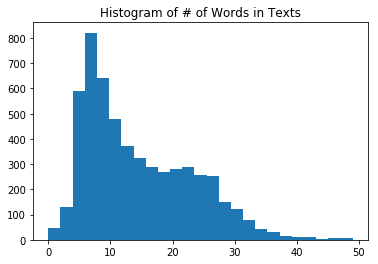

word number: 2108
Training Observation #10: Loss = 0.20103486
Training Observation #20: Loss = 0.15575552
Training Observation #30: Loss = 0.002771888
Training Observation #40: Loss = 2.303629
Training Observation #50: Loss = 0.19538668
Training Observation #60: Loss = 0.2585126
Training Observation #70: Loss = 0.06234446
Training Observation #80: Loss = 1.5133346
Training Observation #90: Loss = 0.00022708473
Training Observation #100: Loss = 0.034094024
Training Observation #110: Loss = 0.00016983776
Training Observation #120: Loss = 0.15263236
Training Observation #130: Loss = 0.086983845
Training Observation #140: Loss = 0.0045453524
Training Observation #150: Loss = 0.83123845
Training Observation #160: Loss = 0.0021430175
Training Observation #170: Loss = 0.000166159
Training Observation #180: Loss = 4.312133
Training Observation #190: Loss = 0.001238126
Training Observation #200: Loss = 0.0055020587
Training Observation #210: Loss = 0.034257334
Training Observation #220: Loss = 

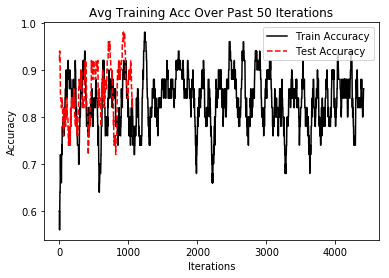

In [9]:
# 7-2 recipe 42
## BoW model(文章中の単語をそのまま情報量として使う)
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import csv
import string
import requests
import io
from zipfile import ZipFile
from tensorflow.contrib import learn
from tensorflow.python.framework import ops

ops.reset_default_graph()
sess = tf.Session()

# load data
save_file_name = os.path.join('data', 'temp_spam_data.csv')

if not os.path.exists('temp'):
    os.makedirs('temp')

if os.path.isfile(save_file_name):
    text_data = []
    with open(save_file_name, 'r') as temp_output_file:
        reader = csv.reader(temp_output_file)
        for row in reader:
            text_data.append(row)
else:
    zip_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    r = requests.get(zip_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read('SMSSpamCollection')   
    text_data = file.decode()
    text_data = text_data.encode('ascii', errors='ignore')
    text_data = text_data.decode().split('\n')
    text_data = [x.split('\t') for x in text_data if len(x)>=1]

    with open(save_file_name, 'w') as temp_output_file:
        writer = csv.writer(temp_output_file)
        writer.writerows(text_data)

print('row number: ' + str(len(text_data)))
    
# 0: ham or spam flag, 1: title
texts = [x[1] for x in text_data]
target = [x[0] for x in text_data]
target = [1 if x == 'spam' else 0 for x in target]

# extract text
## change to lower text
texts = [x.lower() for x in texts]
## delete ','
texts = [''.join(c for c in x if c not in string.punctuation) for x in texts]
## delete 'number'
texts = [''.join(c for c in x if c not in '0123456789') for x in texts]
## delete ' '
texts = [' '.join(x.split()) for x in texts]

# plot length of text by hist
text_lengths = [len(x.split()) for x in texts]
text_lengths = [x for x in text_lengths if x < 50]
plt.hist(text_lengths, bins = 25)
plt.title('Histogram of # of Words in Texts')
plt.show()

# split data to train-data and test-data
train_indices = np.random.choice(len(texts), round(len(texts)*0.8),
                                     replace=False)
test_indices = np.array(list(set(range(len(texts))) - set(train_indices)))
texts_train = [x for ix, x in enumerate(texts) if ix in train_indices]
texts_test = [x for ix, x in enumerate(texts) if ix in test_indices]
target_train = [x for ix, x in enumerate(target) if ix in train_indices]
target_test = [x for ix, x in enumerate(target) if ix in test_indices]

# set parameter for tuning BOW
sentence_size = 25
min_word_freq = 3

# prepear word vector for Word Embbeding
## restrict word number of text to 25 words
vocab_processor = learn.preprocessing.VocabularyProcessor(
    sentence_size, min_frequency = min_word_freq)
vocab_processor.fit_transform(texts)
embedding_size = len(vocab_processor.vocabulary_)
print("word number: " + str(embedding_size))

# define variables and placeholder
A = tf.Variable(tf.random_normal(shape = [embedding_size, 1]))
b = tf.Variable(tf.random_normal(shape = [1, 1]))

x_data = tf.placeholder(shape = [sentence_size], dtype = tf.int32)
y_target = tf.placeholder(shape = [1, 1], dtype = tf.float32)

# change index-array to one-hot vector
identity_mat = tf.diag(tf.ones(shape=[embedding_size]))
## extract x_data(25 words) from embedding vector(about 2000)
## change word to vector
x_embed = tf.nn.embedding_lookup(identity_mat, x_data)
x_cols_sums = tf.reduce_sum(x_embed, 0)

# define model(y = A * x + b: 2000(ex: You have the meeting.) -> 1(ex: 'ham'))
x_col_sums_2D = tf.expand_dims(x_cols_sums, 0)
model_output = tf.add(tf.matmul(x_col_sums_2D, A), b)
prediction = tf.sigmoid(model_output)

# define loss function
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits = model_output, labels = y_target))

# define optimization function
my_opt = tf.train.GradientDescentOptimizer(0.001)
train_step = my_opt.minimize(loss)

# initlize
init = tf.global_variables_initializer()
sess.run(init)

# update variables
loss_vec = []
train_acc_all = []
train_acc_avg = []
## turn count of train's sentence times
for ix, t in enumerate(vocab_processor.fit_transform(texts_train)):
    y_data = [[target_train[ix]]]
    sess.run(train_step, feed_dict = {x_data: t, y_target: y_data})
    
    temp_loss = sess.run(loss, feed_dict = {x_data: t, y_target: y_data})
    loss_vec.append(temp_loss)
    
    if (ix+1)%10==0:
        print('Training Observation #' + str(ix+1) + ': Loss = ' + str(temp_loss))

    # 正解率の移動平均を追跡
    ## 1つの観測の予測値を取得
    [[temp_pred]] = sess.run(prediction, feed_dict={x_data: t, y_target: y_data})
    ## 予測が正解かどうかを真偽値で取得
    train_acc_temp = target_train[ix]==np.round(temp_pred)
    train_acc_all.append(train_acc_temp)
    if len(train_acc_all) >= 50:
        train_acc_avg.append(np.mean(train_acc_all[-50:]))
        
test_acc_all = []
test_acc_avg = []
for ix, t in enumerate(vocab_processor.fit_transform(texts_test)):
    y_data = [[target_test[ix]]]
    if (ix+1)%50 == 0:
        print('Test Observation #' + str(ix+1))
    
    [[temp_pred]] = sess.run(prediction, feed_dict={x_data: t, y_target: y_data})
    
    test_acc_temp = target_test[ix]==np.round(temp_pred)
    test_acc_all.append(test_acc_temp)
    if len(test_acc_all) >= 50:
        test_acc_avg.append(np.mean(test_acc_all[-50:]))

#    print('\nOverall Test Accuracy: {}'.format(np.mean(test_acc_all)))
    
plt.plot(range(len(train_acc_avg)), train_acc_avg, 'k-', label='Train Accuracy')
plt.plot(range(len(test_acc_avg)), test_acc_avg, 'r--', label='Test Accuracy')
plt.title('Avg Training Acc Over Past 50 Iterations')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.show()

In [10]:
# test vocabularyprocessor 

import numpy as np
from tensorflow.contrib import learn

x_text = ['This is a cat','This must be boy', 'This is a a dog']
#max_document_length = max([len(x.split(" ")) for x in x_text])
# test: restrict word number in text
max_document_length = 3

## Create the vocabularyprocessor object, setting the max lengh of the documents.
vocab_processor = learn.preprocessing.VocabularyProcessor(max_document_length)

## Transform the documents using the vocabulary.
x = np.array(list(vocab_processor.fit_transform(x_text)))    

## Extract word:id mapping from the object.
vocab_dict = vocab_processor.vocabulary_._mapping

## Sort the vocabulary dictionary on the basis of values(id).
## Both statements perform same task.
#sorted_vocab = sorted(vocab_dict.items(), key=operator.itemgetter(1))
sorted_vocab = sorted(vocab_dict.items(), key = lambda x : x[1])

## Treat the id's as index into list and create a list of words in the ascending order of id's
## word with id i goes at index i of the list.
vocabulary = list(list(zip(*sorted_vocab))[0])

print(vocabulary)
print(x)

['<UNK>', 'This', 'is', 'a', 'cat', 'must', 'be', 'boy', 'dog']
[[1 2 3]
 [1 5 6]
 [1 2 3]]


row number: 5574


/Users/tomo_will/.pyenv/versions/3.5.0/envs/sandbox350/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


1000
Generation # 500. Train Loss (Test Loss): 0.87 (1.00). Train Acc (Test Acc): 0.45 (0.35)
Generation # 1000. Train Loss (Test Loss): 0.77 (0.80). Train Acc (Test Acc): 0.52 (0.51)
Generation # 1500. Train Loss (Test Loss): 0.62 (0.68). Train Acc (Test Acc): 0.68 (0.62)
Generation # 2000. Train Loss (Test Loss): 0.58 (0.61). Train Acc (Test Acc): 0.70 (0.69)
Generation # 2500. Train Loss (Test Loss): 0.57 (0.56). Train Acc (Test Acc): 0.76 (0.73)
Generation # 3000. Train Loss (Test Loss): 0.47 (0.53). Train Acc (Test Acc): 0.80 (0.77)
Generation # 3500. Train Loss (Test Loss): 0.43 (0.51). Train Acc (Test Acc): 0.86 (0.79)
Generation # 4000. Train Loss (Test Loss): 0.46 (0.50). Train Acc (Test Acc): 0.83 (0.80)
Generation # 4500. Train Loss (Test Loss): 0.40 (0.49). Train Acc (Test Acc): 0.89 (0.81)
Generation # 5000. Train Loss (Test Loss): 0.50 (0.49). Train Acc (Test Acc): 0.81 (0.82)
Generation # 5500. Train Loss (Test Loss): 0.47 (0.48). Train Acc (Test Acc): 0.83 (0.83)
Genera

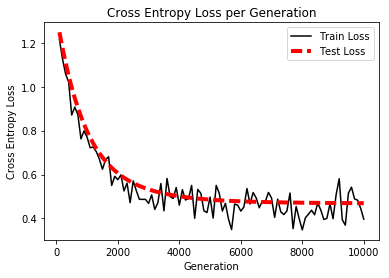

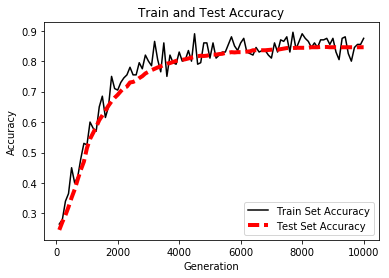

In [11]:
# 7-3 recipe 43
## TF-IDF（出現単語の頻度を考慮して重み付けを行う、全体での出現頻度が少ないが、
## ある文章中の出現頻度が高い場合には、重みを高くする。）
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import numpy as np
import os
import string
import requests
import io
import nltk
from zipfile import ZipFile
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.python.framework import ops

ops.reset_default_graph()
sess = tf.Session()

batch_size = 200
max_features = 1000

# load data
save_file_name = os.path.join('data', 'temp_spam_data.csv')

if not os.path.exists('temp'):
    os.makedirs('temp')

if os.path.isfile(save_file_name):
    text_data = []
    with open(save_file_name, 'r') as temp_output_file:
        reader = csv.reader(temp_output_file)
        for row in reader:
            text_data.append(row)
else:
    zip_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    r = requests.get(zip_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read('SMSSpamCollection')
    text_data = file.decode()
    text_data = text_data.encode('ascii', errors='ignore')
    text_data = text_data.decode().split('\n')
    text_data = [x.split('\t') for x in text_data if len(x)>=1]

    with open(save_file_name, 'w') as temp_output_file:
        writer = csv.writer(temp_output_file)
        writer.writerows(text_data)

print('row number: ' + str(len(text_data)))

# 0: ham or spam flag, 1: title
texts = [x[1] for x in text_data]
target = [x[0] for x in text_data]
target = [1. if x == 'spam' else 0. for x in target]

# extract text
## change to lower text
texts = [x.lower() for x in texts]
## delete ','
texts = [''.join(c for c in x if c not in string.punctuation) for x in texts]
## delete 'number'
texts = [''.join(c for c in x if c not in '0123456789') for x in texts]
## delete ' '
texts = [' '.join(x.split()) for x in texts]

# tokenize(ex: This is a cat. -> This/is/a/cat)
def tokenizer(text):
    words = nltk.word_tokenize(text)
    return words

# create tfidf
## TfidfVectorizer + fit_transform(ex: This is a cat. -> [ 0.4 0.77 0.49 0.45] )
tfidf = TfidfVectorizer(tokenizer = tokenizer, stop_words = 'english', max_features = max_features)
sparse_tfidf_texts = tfidf.fit_transform(texts)
## sparse matrix -> normal matrix(toarray:numpy.ndarray. todense:numpy.matrix)
print(len(sparse_tfidf_texts.toarray()[0]))

# split data to train-data and test-data
train_indices = np.random.choice(sparse_tfidf_texts.shape[0],
                                 round(sparse_tfidf_texts.shape[0]*0.8),
                                 replace=False)
test_indices = np.array(list(set(range(sparse_tfidf_texts.shape[0])) - set(train_indices)))
texts_train = sparse_tfidf_texts[train_indices]
texts_test = sparse_tfidf_texts[test_indices]
target_train = np.array([x for ix, x in enumerate(target) if ix in train_indices])
target_test = np.array([x for ix, x in enumerate(target) if ix in test_indices])

# define variables and placeholder
A = tf.Variable(tf.random_normal(shape = [max_features, 1]))
b = tf.Variable(tf.random_normal(shape = [1, 1]))

x_data = tf.placeholder(shape = [None, max_features], dtype = tf.float32)
y_target = tf.placeholder(shape = [None, 1], dtype = tf.float32)

# define model (y = A * x + b)
model_output = tf.add(tf.matmul(x_data, A), b)
prediction = tf.round(tf.sigmoid(model_output))
predictions_correct = tf.cast(tf.equal(prediction, y_target), tf.float32)
accuracy = tf.reduce_mean(predictions_correct)

# define loss function
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits = model_output, labels = y_target))

# define optimization function
my_opt = tf.train.GradientDescentOptimizer(0.0025)
train_step = my_opt.minimize(loss)

# initialize
init = tf.global_variables_initializer()
sess.run(init)

# update variables
train_loss = []
test_loss = []
train_acc = []
test_acc = []
i_data = []
for i in range(10000):
    rand_index = np.random.choice(texts_train.shape[0], size = batch_size)
    rand_x = texts_train[rand_index].todense()
    rand_y = np.transpose([target_train[rand_index]])
    sess.run(train_step, feed_dict = {x_data: rand_x, y_target: rand_y})
    
    if (i+1)%100 == 0:
        i_data.append(i+1)
        train_loss_temp = sess.run(loss, feed_dict={
            x_data: rand_x,
            y_target: rand_y
        })
        train_loss.append(train_loss_temp)

        test_loss_temp = sess.run(loss, feed_dict={
            x_data: texts_test.todense(),
            y_target: np.transpose([target_test])
        })
        test_loss.append(test_loss_temp)
        
        train_acc_temp = sess.run(accuracy, feed_dict={
            x_data: rand_x,
            y_target: rand_y
        })
        train_acc.append(train_acc_temp)
        
        test_acc_temp = sess.run(accuracy, feed_dict={
            x_data: texts_test.todense(),
            y_target: np.transpose([target_test])
        })
        test_acc.append(test_acc_temp)

    if (i+1)%500 == 0:
        acc_and_loss = [i+1, train_loss_temp, test_loss_temp, train_acc_temp, test_acc_temp]
        acc_and_loss = [np.round(x, 2) for x in acc_and_loss]
        print('Generation # {}. Train Loss (Test Loss): {:.2f} ({:.2f}). '
             'Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))

# 損失値をプロット
plt.plot(i_data, train_loss, 'k-', label='Train Loss')
plt.plot(i_data, test_loss, 'r--', label='Test Loss', linewidth=4)
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.legend(loc='upper right')
plt.show()
# 正解率をプロット
plt.plot(i_data, train_acc, 'k-', label='Train Set Accuracy')
plt.plot(i_data, test_acc, 'r--', label='Test Set Accuracy', linewidth=4)
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [16]:
# 7-4 recipe 44
## skipgram（単語の順序も考慮して、単語から前後の単語を予測する）
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import string
import requests
import collections
import io
import tarfile
import urllib.request
from nltk.corpus import stopwords
from tensorflow.python.framework import ops

ops.reset_default_graph()
sess = tf.Session()

# set parameter
batch_size = 100
embedding_size = 200
vocabulary_size = 10000
generations = 10000
num_sampled = int(batch_size / 2)
window_size = 5

## paramete for print
print_loss_every = 1000

stops = stopwords.words('english')

# settinct for test
print_valid_every = 5000
valid_words = ['cliche', 'love', 'hate', 'silly', 'sad']

#os.chdir(os.path.dirname(os.path.realpath(__file__)))
def load_movie_data():
    save_folder_name = 'data'
    pos_file = os.path.join(save_folder_name, 'rt-polaritydata', 'rt-polarity.pos')
    neg_file = os.path.join(save_folder_name, 'rt-polaritydata', 'rt-polarity.neg')

    if not os.path.exists(os.path.join(save_folder_name, 'rt-polaritydata')):
        movie_data_url = 'http://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.tar.gz'

        req = requests.get(movie_data_url, stream=True)
        with open(os.path.join(save_folder_name, 'temp_movie_review_temp.tar.gz'), 'wb') as f:
            for chunk in req.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
                    f.flush()

        tar = tarfile.open(os.path.join(save_folder_name, 'temp_movie_review_temp.tar.gz'), "r:gz")
        tar.extractall(path='data')
        tar.close()
    pos_data = []
    with open(pos_file, 'r', encoding='latin-1') as f:
        for line in f:
            pos_data.append(line.encode('ascii', errors='ignore').decode())
    f.close()
    pos_data = [x.rstrip() for x in pos_data]
    neg_data = []
    with open(neg_file, 'r', encoding='latin-1') as f:
        for line in f:
            neg_data.append(line.encode('ascii', errors='ignore').decode())
    f.close()
    neg_data = [x.rstrip() for x in neg_data]
    texts = pos_data + neg_data
    target = [1]*len(pos_data) + [0]*len(neg_data)
    
    return(texts, target)

texts, target = load_movie_data()

def normalize_text(texts, stops):
    # 小文字に変換
    texts = [x.lower() for x in texts]
    # 句読点を削除
    texts = [''.join(c for c in x if c not in string.punctuation)
                 for x in texts]
    # 数字を削除
    texts = [''.join(c for c in x if c not in '0123456789') for x in texts]
    # ストップワードを削除
    texts = [' '.join([word for word in x.split() if word not in (stops)])
                 for x in texts]
    # 余分なホワイトスペースを削除
    texts = [' '.join(x.split()) for x in texts]
    return(texts)

texts = normalize_text(texts, stops)

target = [target[ix] for ix, x in enumerate(texts) if len(x.split()) > 2]
texts = [x for x in texts if len(x.split()) > 2]

# create dictionary ex:{word: word_count}
def build_dictionary(sentences, vocabulary_size):
    split_sentences = [s.split() for s in sentences]
    words = [x for sublist in split_sentences for x in sublist]
    
    count = [['RARE', -1]]
    # add frequent (vocabulary_size) word
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    
    word_dict = {}
    
    for word, word_count in count:
        word_dict[word] = len(word_dict)

    return(word_dict)

# change word to word_index
def text_to_numbers(sentences, word_dict):
    data = []
    for sentence in sentences:
        sentence_data = []
        for word in sentence.split(' '):
            if word in word_dict:
                word_ix = word_dict[word]
            else:
                word_ix = 0
            sentence_data.append(word_ix)
        data.append(sentence_data)
    return(data)

word_dictionary = build_dictionary(texts, vocabulary_size)
# ex:{11: 'cat'}
word_dictionary_rev = dict(zip(word_dictionary.values(), word_dictionary.keys()))
# I have a pen. -> [[1 2 3 4], ...]
text_data = text_to_numbers(texts, word_dictionary)

valid_examples = [word_dictionary[x] for x in valid_words]

# output
## batch: 
## labels:
def generate_batch_data(sentences, batch_size, window_size,
                       method = 'skip_gram'):

    batch_data = []
    label_data = []
    while len(batch_data) < batch_size:
        rand_sentence = np.random.choice(sentences)
        # create window of each sentence
        window_sequences = [rand_sentence[max((ix-window_size), 0): (ix+window_size+1)]
                            for ix, x in enumerate(rand_sentence)]
        label_indices = [ix if ix < window_size else window_size
                        for ix, x in enumerate(window_sequences)]
        # create (oubject_word, window_words)
        if method == 'skip_gram':
            batch_and_labels = [(x[y], x[:y] + x[(y+1):])
                               for x, y in zip(window_sequences, label_indices)]
            tuple_data = [(x, y_) for x, y in batch_and_labels for y_ in y]
        else:
            raise ValueError('Method {} not implmented yet.'.format(method))
        
        batch, labels = [list(x) for x in zip(*tuple_data)]
        #batch_and_labels: <class 'list'>: [(476, [358, 0, 18, 305, 957]), (358, [476, 0, 18, 305, 957, 146]), (0, [476, 358, 18, 305, 957, 146, 236]), (18, [476, 358, 0, 305, 957, 146, 236, 12]), (305, [476, 358, 0, 18, 957, 146, 236, 12]), (957, [476, 358, 0, 18, 305, 146, 236, 12]), (146, [358, 0, 18, 305, 957, 236, 12]), (236, [0, 18, 305, 957, 146, 12]), (12, [18, 305, 957, 146, 236])]
        #batch: <class 'list'>: [476, 476, 476, 476, 476, 358, 358, 358, 358, 358, 358, 0, 0, 0, 0, 0, 0, 0, 18, 18, 18, 18, 18, 18, 18, 18, 305, 305, 305, 305, 305, 305, 305, 305, 957, 957, 957, 957, 957, 957, 957, 957, 146, 146, 146, 146, 146, 146, 146, 236, 236, 236, 236, 236, 236, 12, 12, 12, 12, 12]
        #lavel: <class 'list'>: [358, 0, 18, 305, 957, 476, 0, 18, 305, 957, 146, 476, 358, 18, 305, 957, 146, 236, 476, 358, 0, 305, 957, 146, 236, 12, 476, 358, 0, 18, 957, 146, 236, 12, 476, 358, 0, 18, 305, 146, 236, 12, 358, 0, 18, 305, 957, 236, 12, 0, 18, 305, 957, 146, 12, 18, 305, 957, 146, 236]
        batch_data.extend(batch[:batch_size])
        label_data.extend(labels[:batch_size])
    
    batch_data = batch_data[:batch_size]
    label_data = label_data[:batch_size]
    
    batch_data = np.array(batch_data)
    label_data = np.transpose(np.array([label_data]))
    
    return(batch_data, label_data)

# initialize embedding matrix (for input data) -> 'cat': [0.1 0.23 ... 0.2]
## tuning parameter in training
embeddings = tf.Variable(
         tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))

# define placeholder
x_inputs = tf.placeholder(tf.int32, shape=[batch_size])
y_target = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

## extract x_inputs(100 sentences) from embedding vector(about 200) -> word vector
embed = tf.nn.embedding_lookup(embeddings, x_inputs)
print(embed)

# define loss function
## tuning parameter in training
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                                             stddev = 1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
# Noise Contrastive Estimation (NCE)
# 参考：http://enakai00.hatenablog.com/entry/2016/03/22/102437
loss = tf.reduce_mean(tf.nn.nce_loss(weights = nce_weights,
                                    biases = nce_biases,
                                    labels = y_target,
                                    inputs = embed,
                                    num_sampled = num_sampled,
                                    num_classes = vocabulary_size
                                    ))

# define evaluation model
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims = True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,
                                         valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings,
                      transpose_b = True)

# define optimazation function
optimizer = tf.train.GradientDescentOptimizer(learning_rate=1.0).minimize(loss)

# initialize
init = tf.global_variables_initializer()
sess.run(init)

# updata variable
loss_vec = []
loss_x_vec = []
for i in range(generations):
    batch_inputs, batch_labels = generate_batch_data(
                                text_data, batch_size, window_size)
    # in - out (ex: I have a pen. -> (I, have), (I, a), (I, pen)
    feed_dict = {x_inputs: batch_inputs, y_target: batch_labels}
    sess.run(optimizer, feed_dict = feed_dict)
    
    if (i+1) % print_loss_every == 0:
        loss_val = sess.run(loss, feed_dict=feed_dict)
        loss_vec.append(loss_val)
        loss_x_vec.append(i+1)
        print("Loss at step {} : {}".format(i+1, loss_val))
        
    if (i+1) % print_valid_every == 0:
        sim = sess.run(similarity)
        for j in range(len(valid_words)):
            valid_word = word_dictionary_rev[valid_examples[j]]
            top_k = 5
            nearest = (-sim[j, :]).argsort()[1:top_k+1]
            log_str = "Nearest to {}:".format(valid_word)
            for k in range(top_k):
                class_word = word_dictionary_rev[nearest[k]]
                log_str = "%s %s," % (log_str, class_word)
            print(log_str)

Tensor("embedding_lookup:0", shape=(100, 200), dtype=float32)
Loss at step 1000 : 20.57477378845215
Loss at step 2000 : 19.780200958251953
Loss at step 3000 : 5.389079570770264
Loss at step 4000 : 3.8295764923095703
Loss at step 5000 : 4.996992111206055
Nearest to cliche: meaningless, lecture, emup, lynch, predecessors,
Nearest to love: moment, wartime, ecks, helped, swooping,
Nearest to hate: saw, theyd, gamut, sinister, coma,
Nearest to silly: president, movie, littleknown, porridge, film,
Nearest to sad: terms, copy, writerdirectors, christopher, element,
Loss at step 6000 : 4.516148090362549
Loss at step 7000 : 4.279176712036133
Loss at step 8000 : 4.752163887023926
Loss at step 9000 : 4.31609582901001
Loss at step 10000 : 4.009848594665527
Nearest to cliche: meaningless, blandly, lecture, eat, lynch,
Nearest to love: film, relatives, seasoned, RARE, helped,
Nearest to hate: theyd, gamut, saw, sinister, coma,
Nearest to silly: movie, president, porridge, gored, littleknown,
Nearest